# Trading BTC with Google Trends

## Motivation

[Google Trends](https://trends.google.com/trends/) allows you to explore how popular a particular search term was over time. Could this data on what is being searched on Google be used as an indicator of changes in BTC's price and as the basis for a trading strategy?

## Notebook setup

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr

In [2]:
plt.style.use("seaborn")

## The data

### BTC price data

I'll be using the last 5 years' worth of BTC-USD price data from [Yahoo Finance](https://finance.yahoo.com/). Note that, as of this time, Yahoo Finance sources it's BTC-USD data from [CryptoCompare](https://www.cryptocompare.com).

You can uncomment the lines below if you wish to download the data directly from Yahoo Finance yourself, but I've already included a `.csv` file with the data.

In [3]:
#btc = pdr.get_data_yahoo("BTC-USD",
#                          start=dt.datetime(2014, 1, 1),
#                          end=dt.datetime(2019, 2, 26))

#btc.to_csv(r'data/btc_price.csv', sep=",")
btc = pd.read_csv("data/btc_price.csv",
                  sep=",", 
                  header=0,
                  index_col=0,
                  parse_dates=True)

btc.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-01,829.929993,770.969971,805.940002,815.940002,8663855,815.940002
2014-01-02,886.210022,810.469971,815.940002,856.909973,10826907,856.909973
2014-01-03,888.229980,839.440002,856.909973,884.260010,8409629,884.260010
2014-01-04,932.159973,848.320007,884.260010,924.690002,12784626,924.690002
2014-01-05,1029.859985,911.359985,924.690002,1014.739990,20789364,1014.739990


However, the Yahoo Finance data contains duplicate information for a few days:

In [4]:
duplicate_days = btc[btc.index.duplicated()].index

print(duplicate_days)
btc.loc[duplicate_days]

DatetimeIndex(['2014-03-30', '2015-03-29', '2016-03-27', '2017-03-26',
               '2018-03-25'],
              dtype='datetime64[ns]', name='Date', freq=None)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-03-30,479.040009,424.029999,477.109985,446.920013,1769770,446.920013
2014-03-30,473.429993,422.489990,446.920013,444.660004,1850592,444.660004
2015-03-29,252.809998,238.929993,252.020004,242.080002,18971340,242.080002
2015-03-29,248.830002,236.550003,242.080002,246.789993,20963830,246.789993
2016-03-27,427.359985,415.500000,416.510010,424.570007,26137150,424.570007
2016-03-27,425.359985,419.700012,424.570007,422.209991,18410749,422.209991
2017-03-26,1048.849976,961.799988,969.440002,1045.140015,92332221,1045.140015
2017-03-26,1004.320007,946.650024,966.299988,969.440002,83255983,969.440002
2018-03-25,8690.360352,8395.849609,8548.389648,8472.839844,657643520,8472.839844


To deal with this we'll:

- Keep the first entry for each duplicate day
- Since we only need the `Close` price, we can fill that in with the `Open` price for the following day

In [5]:
btc = btc[~btc.index.duplicated(keep="first")] # Note that btc[btc.index.duplicated(keep="first")] returns the last duplicate rows

In [6]:
for i in duplicate_days:
    next_day = i + dt.timedelta(days=1)
    btc.loc[i, "Close"] = btc.loc[next_day, "Open"]

btc[btc.index.duplicated()].index

DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)

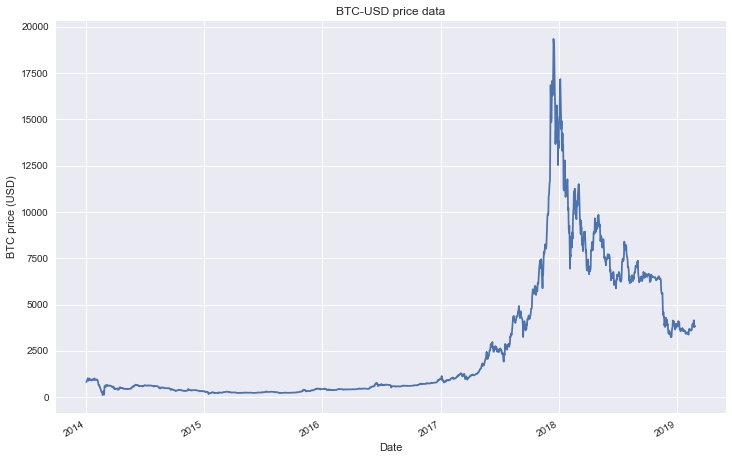

<Figure size 576x396 with 0 Axes>

In [7]:
btc["Close"].plot(figsize=(12, 8))
plt.title("BTC-USD price data")
plt.ylabel("BTC price (USD)")
plt.show()
plt.clf()

### Google Trends data

You can download the Google Trends data on the search term "bitcoin" [here](https://trends.google.com/trends/explore?date=today%205-y&q=bitcoin). I've included it in the `data/google_trends_btc.csv` file.

A few observations:

- I'll be using the last 5 years worth of data (from `2014-03-02` to `2019-02-24`)
- I'll be using "worldwide" data (Google Trends allows you to narrow down search trends to particular geographies)
- Google Trends provides us with the preceding week's data on the popularity of the search term in question. That is, each line in the `.csv` file contains the popularity of the search term in the last 7 days.
- Weeks end on Sunday
- The numbers provided by Google Trends don't represent the actual number of searches for the term in question. Rather, they represent search interest relative to the highest point on the chart for the given region and time period. That is:
    - A value of 100 is the peak popularity for the term.
    - A value of 50 means that the term is half as popular.
    - A score of 0 means there was not enough data for this term.

Let's take a look at the resulting file:

In [8]:
!head data/google_trends_btc.csv

Week,bitcoin
2014-03-02,9
2014-03-09,5
2014-03-16,4
2014-03-23,4
2014-03-30,4
2014-04-06,3
2014-04-13,3
2014-04-20,3
2014-04-27,3


Importing it into a DataFrame:

In [9]:
google_trends_data = pd.read_csv("data/google_trends_btc.csv",
                                 sep=",",
                                 header=0,
                                 index_col=0,
                                 parse_dates=True)

google_trends_data.head()

,bitcoin
Week,
2014-03-02,9
2014-03-09,5
2014-03-16,4
2014-03-23,4
2014-03-30,4


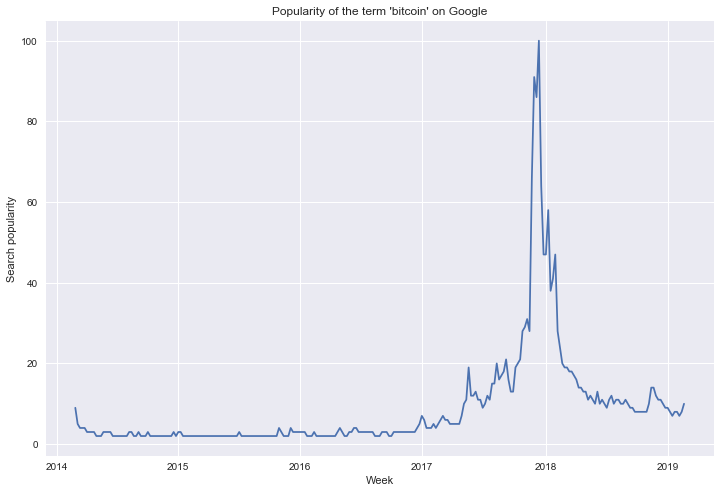

<Figure size 576x396 with 0 Axes>

In [10]:
google_trends_data["bitcoin"].plot(figsize=(12, 8))
plt.title("Popularity of the term 'bitcoin' on Google")
plt.ylabel("Search popularity")
plt.show()
plt.clf()

### Merging the 2 datasets

We will

- Join the 2 DataFrames based on the index of our Google Trends data (since our Google Trends data is at weekly frequency and our price data is daily)
- Select only the columns we wish to keep

In [11]:
df = pd.DataFrame.join(btc, google_trends_data, how="right")
df = df[["Close", "bitcoin"]]

df.head()

,Close,bitcoin
Week,,
2014-03-02,544.559998,9
2014-03-09,627.049988,5
2014-03-16,619.140015,4
2014-03-23,551.159973,4
2014-03-30,444.660004,4


Now we have our `df` DataFrame with closing prices and search interest for bitoin for the previous week.

However, we can see there are a few dates with mising prices:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2014-03-02 to 2019-02-24
Data columns (total 2 columns):
Close      256 non-null float64
bitcoin    261 non-null int64
dtypes: float64(1), int64(1)
memory usage: 6.1 KB


In [13]:
missing_dates_close = df[df.isnull().any(axis=1)]

missing_dates_close

,Close,bitcoin
Week,,
2014-10-26,NaN,2
2015-10-25,NaN,2
2016-10-30,NaN,3
2017-10-29,NaN,28
2018-10-28,NaN,8


These are due to missing days in the Yahoo Finance dataset.

We can fill these in with the `Open` value for the following day:

In [14]:
for i in missing_dates_close.index:
    next_day = i + dt.timedelta(days=1)
    df.loc[i, "Close"] = btc.loc[next_day, "Open"]

print("Filled-in missing dates:\n\n", df.loc[missing_dates_close.index], "\n\n")
print(df.info())

Filled-in missing dates:

                   Close  bitcoin
Week                            
2014-10-26   348.670013        2
2015-10-25   287.859985        2
2016-10-30   697.270020        3
2017-10-29  6147.700195       28
2018-10-28  6470.740234        8 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2014-03-02 to 2019-02-24
Data columns (total 2 columns):
Close      261 non-null float64
bitcoin    261 non-null int64
dtypes: float64(1), int64(1)
memory usage: 16.1 KB
None


## Preliminary overview of our data

If the Google Trends data is to be used as a signal for the price of BTC, the two must be highly correlated. Let's check:

In [15]:
df.corr().iloc[0, 1]

0.8177241510846407

A `+0.82` correlation is fairly strong, which is promising.

Let's now plot the two:

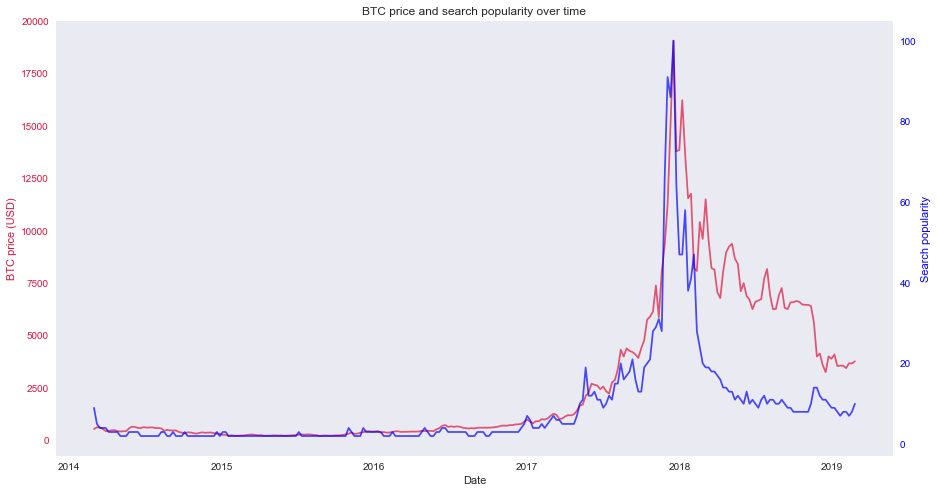

<Figure size 576x396 with 0 Axes>

In [16]:
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.plot(df.index, df["Close"], color="crimson", alpha=0.7)
ax1.set_xlabel("Date")
ax1.set_ylabel("BTC price (USD)", color="crimson")
ax1.tick_params('y', colors='crimson')

ax2 = ax1.twinx()
ax2.plot(df.index, df["bitcoin"], color="blue", alpha=0.7)
ax2.set_ylabel("Search popularity", color="blue")
ax2.tick_params('y', colors='blue')

ax1.grid(False)
ax2.grid(False)

plt.title("BTC price and search popularity over time")

plt.show()
plt.clf()

From the graph above we can see that, despite the relatively strong `+0.82` correlation between our two series, this correlation seems to vary quite significantly accross different time periods. We can be more thorough, and check whether that's actually the case.

To do so, we can calculate the rolling correlation between the two. I chose a 26-period window (which corresponds to a 6-month rolling window since the frequency of our data is weekly).

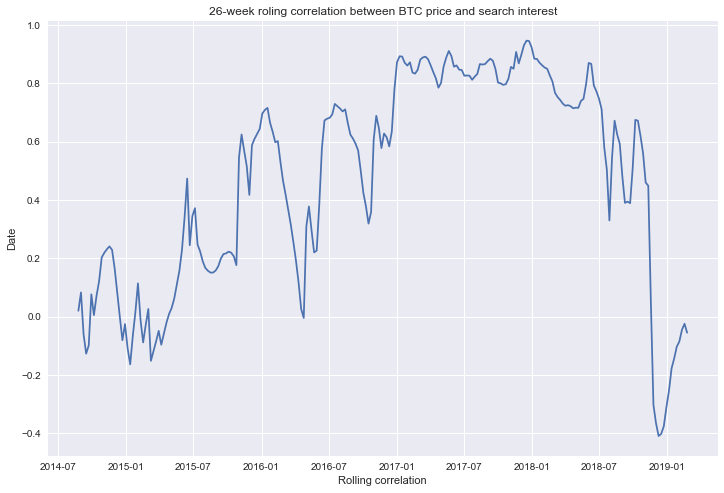

<Figure size 576x396 with 0 Axes>

In [17]:
rolling_correlation = df["Close"].rolling(26).corr(df["bitcoin"])

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(rolling_correlation)
plt.title("26-week roling correlation between BTC price and search interest")
plt.xlabel("Rolling correlation")
plt.ylabel("Date")

plt.show()
plt.clf()

We can confirm from the graph above that, despite de `+0.82` overall correlation, between our two series, the correlation between them does fluctuate quite significantly. It was particularly high during the 2017 bull-run and fell massively thereafter.

This suggests that we'll probably have limited success in using search data on "bitcoin" as an indicator of changes in BTC's price and as the basis for a trading strategy.

## Generating order signals

What exactly are we trying to accomplish? We want to know whether there has been enough change in Google search volume on "bitcoin" from one week to another so that we can execute a trade and make a profit.

The trading strategy that we'll define is to go:

- **Long** BTC if there's **higher** search volume in a week than the average of the preceding 3 weeks (excluding the current week)
- **Short** BTC if there's **lower** search volume in a week than the average of the preceding 3 weeks (excluding the current week)

We begin by calculating the moving average of search interest of the preceding 3 weeks for each week (excluding the current week):

In [18]:
df["mov_avg_3"] = df["bitcoin"].shift(1).rolling(window=3).mean()

df.head()

,Close,bitcoin,mov_avg_3
Week,,,
2014-03-02,544.559998,9,NaN
2014-03-09,627.049988,5,NaN
2014-03-16,619.140015,4,NaN
2014-03-23,551.159973,4,6.000000
2014-03-30,444.660004,4,4.333333


Note that we shift the values by one week before calculating the rolling 3-week mean. Not shifting would include the current week in the average, and we want to make decisions based on the *prior* 3 weeks.

Now we generate the order signals as per the trading strategy defined above where:

- `1` is *long*
- `-1` is *short*

In [19]:
df["signal"] = 0 #Default to 0

df.loc[df["bitcoin"] > df["mov_avg_3"], "signal"] = 1
df.loc[df["bitcoin"] < df["mov_avg_3"], "signal"] = -1

df

,Close,bitcoin,mov_avg_3,signal
Week,,,,
2014-03-02,544.559998,9,NaN,0
2014-03-09,627.049988,5,NaN,0
2014-03-16,619.140015,4,NaN,0
2014-03-23,551.159973,4,6.000000,-1
2014-03-30,444.660004,4,4.333333,-1
2014-04-06,462.380005,3,4.000000,-1
2014-04-13,478.380005,3,3.666667,-1
2014-04-20,495.160004,3,3.333333,-1
2014-04-27,441.920013,3,3.000000,0


## Computing returns

We reinvest our entire portfolio every week. Thus, our %-return over the week is simply the percentage change in BTC's closing price over that week accounted for whether we were long or short.

In [20]:
df["pct_chg_following_week"] = df["Close"].pct_change().shift(-1)

df.head()

,Close,bitcoin,mov_avg_3,signal,pct_chg_following_week
Week,,,,,
2014-03-02,544.559998,9,NaN,0,0.151480
2014-03-09,627.049988,5,NaN,0,-0.012615
2014-03-16,619.140015,4,NaN,0,-0.109798
2014-03-23,551.159973,4,6.000000,-1,-0.193229
2014-03-30,444.660004,4,4.333333,-1,0.039851


Note that we shift the percentage change in BTC's price back one week (which is why we called it `pct_chg_following_week`). We do this because, to calculate our return, we must multiply our order signal by the following week's change in price.

Now we can calculate our %-return each week:

In [21]:
df["return"] = df["signal"]*df["pct_chg_following_week"]

df.head(10)

,Close,bitcoin,mov_avg_3,signal,pct_chg_following_week,return
Week,,,,,,
2014-03-02,544.559998,9,NaN,0,0.151480,0.000000
2014-03-09,627.049988,5,NaN,0,-0.012615,-0.000000
2014-03-16,619.140015,4,NaN,0,-0.109798,-0.000000
2014-03-23,551.159973,4,6.000000,-1,-0.193229,0.193229
2014-03-30,444.660004,4,4.333333,-1,0.039851,-0.039851
2014-04-06,462.380005,3,4.000000,-1,0.034604,-0.034604
2014-04-13,478.380005,3,3.666667,-1,0.035077,-0.035077
2014-04-20,495.160004,3,3.333333,-1,-0.107521,0.107521
2014-04-27,441.920013,3,3.000000,0,-0.025005,-0.000000


## Cumulative return and the result of the strategy

We can now calculate the cumulative return of our strategy:

In [22]:
df["cum_return"] = (1 + df["return"]).cumprod() - 1

df

,Close,bitcoin,mov_avg_3,signal,pct_chg_following_week,return,cum_return
Week,,,,,,,
2014-03-02,544.559998,9,NaN,0,0.151480,0.000000,0.000000
2014-03-09,627.049988,5,NaN,0,-0.012615,-0.000000,0.000000
2014-03-16,619.140015,4,NaN,0,-0.109798,-0.000000,0.000000
2014-03-23,551.159973,4,6.000000,-1,-0.193229,0.193229,0.193229
2014-03-30,444.660004,4,4.333333,-1,0.039851,-0.039851,0.145678
2014-04-06,462.380005,3,4.000000,-1,0.034604,-0.034604,0.106033
2014-04-13,478.380005,3,3.666667,-1,0.035077,-0.035077,0.067237
2014-04-20,495.160004,3,3.333333,-1,-0.107521,0.107521,0.181987
2014-04-27,441.920013,3,3.000000,0,-0.025005,-0.000000,0.181987


As we can see, we've made a profit at the end of our run of this strategy.

Plotting our returns:

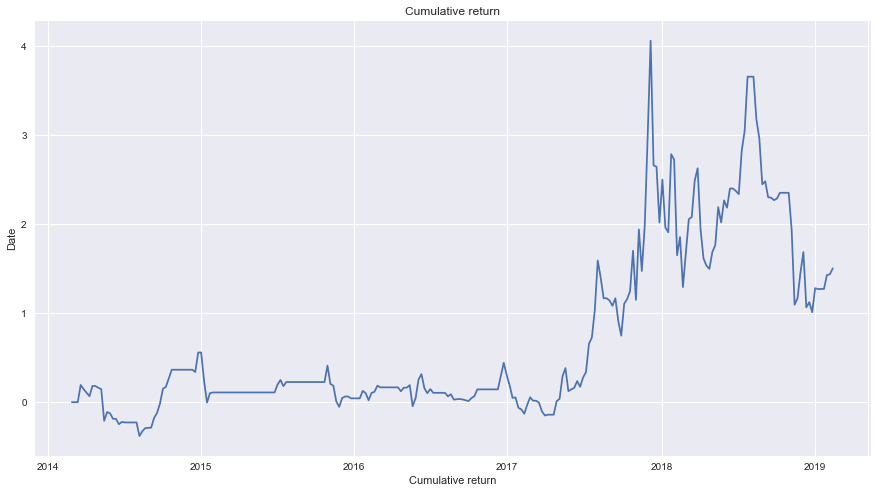

<Figure size 576x396 with 0 Axes>

In [23]:
df["cum_return"].plot(figsize=(15, 8))
plt.title("Cumulative return")
plt.xlabel("Cumulative return")
plt.ylabel("Date")

plt.show()
plt.clf()

How does our strategy compare to simply buying and holding BTC though?

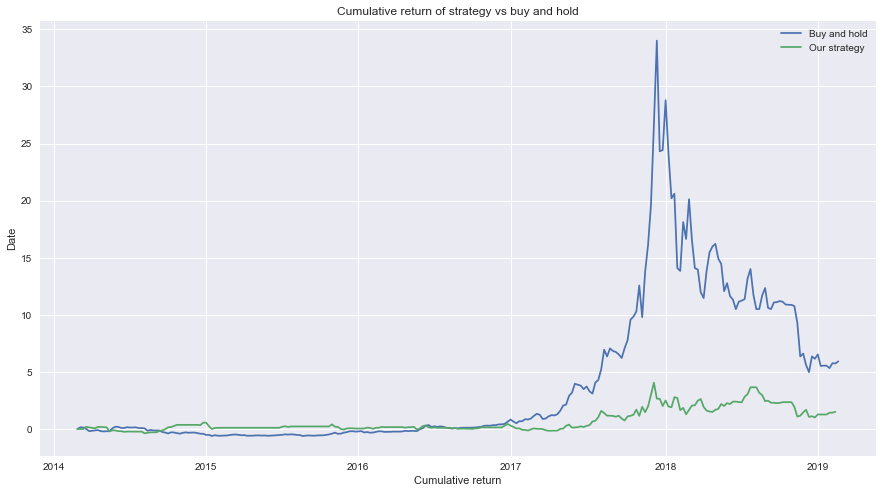

<Figure size 576x396 with 0 Axes>

In [24]:
df["btc_buy_and_hold_cum_return"] = df["Close"]/df.iloc[0]["Close"] - 1

df["btc_buy_and_hold_cum_return"].plot(figsize=(15, 8), label="Buy and hold")
df["cum_return"].plot(label="Our strategy")

plt.title("Cumulative return of strategy vs buy and hold")
plt.xlabel("Cumulative return")
plt.ylabel("Date")
plt.legend()

plt.show()
plt.clf()

In [25]:
df.tail()

,Close,bitcoin,mov_avg_3,signal,pct_chg_following_week,return,cum_return,btc_buy_and_hold_cum_return
Week,,,,,,,,
2019-01-27,3565.080078,8,8.000000,0,-0.032386,-0.000000,1.272120,5.546717
2019-02-03,3449.620117,8,7.666667,1,0.068274,0.068274,1.427247,5.334692
2019-02-10,3685.139893,7,7.666667,-1,-0.003859,0.003859,1.436613,5.767188
2019-02-17,3670.919922,8,7.666667,1,0.027432,0.027432,1.503454,5.741075
2019-02-24,3771.620117,10,7.666667,1,NaN,NaN,NaN,5.925996


As we can see, our strategy seriously underperformed a simple buy and hold strategy.

## Some considerations

Here are a few final considerations:

1. We only used a single search term in our analysis: "bitcoin". Our results might have been significantly better or worse had we used a combination of search terms (for example: "buy bitcoin", "ethereum", "cryptocurrency", "binance" etc) to generate our order signals.
2. We clearly haven't factored transaction costs into our analysis, so actual returns would have underperformed the buy and hold strategy even more as there would have been trading and tax costs involved.

---

This analysis was inspired by an example in chapter 6 in Michael Heydt's [Mastering pandas for Finance](https://www.amazon.com/dp/B00Y9W1838/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1). Check it out if this interested you in any way!